## Toy Model 1: 2 spatial modes with different oscillating frequencies

### Created by Yuying Liu, 09/23/2019

$$\Phi(x, t) = u(x)cos(\omega_0 t) + v(x)cos(\omega_1 t + \frac{\pi}{4})$$

In [33]:
# imports
import os
import sys
import torch
import torch.nn as nn
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm.notebook import tqdm

module_path = os.path.abspath(os.path.join('../../multiscale_HiTS/src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils
import ResNet as tnet

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torch_cae_multilevel_V4 as net
from utils_MrCAE import *


## Simulation 

## MrCAE

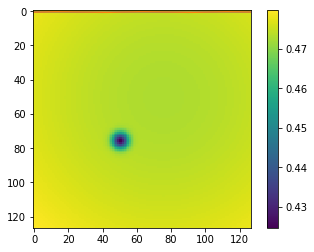

In [2]:
#load data

train_data = np.load('../data/toy1_train_data.npy')
val_data = np.load('../data/toy1_val_data.npy')

plt.plot(train_data[0,:,0,0])
plt.plot(val_data[0,:,0,0])

plt.imshow(train_data[0,0])
plt.colorbar()

Below is the progressive training framework. 
One could have flexible control over each training step: low-level models are cheap to obtain, and higher level models are built based on them -- one can always revert back to the previous level and adjust the parameters to re-train the model if it is not satisfying. 

In [35]:
# init model & load data
data_path = '../data/toy1.npy'
model_path = '../model/toy1_space/'
result_path = '../result/toy1_space/' 

dataset = net.MultiScaleDynamicsDataSet(data_path, n_levels=3)

train_data, val_data, test_data = dataset.obtain_data_at_current_level(1)

In [38]:
dataset.data.shape
data = np.load(data_path)
print(data.shape)

(500, 127, 127)


In [7]:
# trained models at different levels
models_space = {}
print('model names: model_L{level}_{index}')
for file_name in sorted(os.listdir(model_path)):
    model_name, _ = file_name.split('.')
    print(model_name)
    models_space[model_name] = torch.load(os.path.join(model_path, file_name))

model names: model_L{level}_{index}
model_L0_0
model_L0_0_16
model_L0_0_8
model_L0_1
model_L1_0
model_L1_1
model_L2_0


In [5]:
#define some functions
def obtain_data_at_current_level(data, level,n_levels):
#         train_data = self.data[self.train_inds].to(self.device)
#         val_data = self.data[self.val_inds].to(self.device)
#         test_data = self.data[self.test_inds].to(self.device)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        for i in range(n_levels - level - 1):
            data = apply_local_op(data.to(device), device, ave=False)

        return data
    
    
def encode(self, x, level, query_in_out_each_level=False, query_hidden=False):
        """
        :param x: a 4D input of NN
        :param level: level index
        :param query_in_out_each_level: if to query the input/output at each level
        (maybe used for enforce losses at different levels)
        :param query_hidden: if to query hidden representations
        :return: output of NN, a list of hidden representations at current level
        """
        # collectors
        all_hidden = dict()
        all_inputs = dict()
        all_outputs = dict()

        # forward prop
        assert level >= 0, print('level index should be a non-negative integer!')
        resolved_maps_dict = self.resolved_maps[str(level)]

        if self.n_filter_groups_each_level['0'] == 1:
            if query_in_out_each_level:
                all_inputs['0'] = x
            encoded = self._modules['L{}_Conv_0'.format(level)](x)

            return encoded
        #else:
        i = self.n_filter_groups_each_level['0']-1
        encoded = self._modules['L{}_Conv_{}'.format(level, i)](x)
        if self.use_maps:
            masked_encoded = apply_mask(encoded, resolved_maps_dict[str(i - 1)])
        else:
            masked_encoded = encoded
        return masked_encoded
    
def decode(self, encoded, level, y=None, query_in_out_each_level=False, query_hidden=False):
        """
        :param x: a 4D input of NN
        :param level: level index
        :param query_in_out_each_level: if to query the input/output at each level
        (maybe used for enforce losses at different levels)
        :param query_hidden: if to query hidden representations
        :return: output of NN, a list of hidden representations at current level
        """
        # collectors
        all_hidden = dict()
        all_inputs = dict()
        all_outputs = dict()

        # forward prop
        assert level >= 0, print('level index should be a non-negative integer!')
#         resolved_maps_dict = self.resolved_maps[str(level)]

        if self.n_filter_groups_each_level['0'] == 1:
            if query_hidden:
                all_hidden['L0_0'] = encoded
            # ----- pad -----
            encoded = torch.nn.functional.pad(encoded, (1, 1, 1, 1), 'replicate')
            # ---------------
            y = self._modules['L{}_deConv_0'.format(level)](encoded)
            # chop off the boundaries
            y = y[:, :, 2:-2, 2:-2]
            
            
        else:
            i =self.n_filter_groups_each_level['0'] -1
            y = self._modules['L{}_deConv_{}'.format(level, i)](encoded)
            
        return y

torch.Size([500, 1, 15, 15])
torch.Size([500, 1, 31, 31])


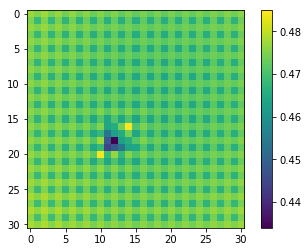

torch.Size([500, 1, 31, 31])


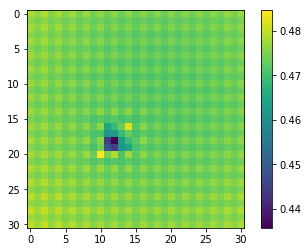

In [32]:
model = models_space['model_L0_0']

data = torch.tensor(train_data[0]).unsqueeze(1).float()
data_this = obtain_data_at_current_level(data, 0,3)
encoded_data_0 = encode(model, data_this, 0)

decoded_data_0 = decode(model, encoded_data_0, 0)


model = models_space['model_L0_1']
encoded_data = encode(model, data_this, 0)
print(encoded_data.shape)

decoded_data = decode(model, encoded_data, 0) + decoded_data_0

print(decoded_data.shape)
plt.imshow(decoded_data[0,0].cpu().detach().numpy())
plt.colorbar()
plt.show()

forwarded_1,_,_,_ = model.forward(data_this, 0)
print(forwarded_1.shape)

plt.imshow(forwarded_1[0,0].cpu().detach().numpy())
plt.colorbar()
plt.show()

# plt.plot(decoded_data[:,0,18,12].cpu().detach().numpy())
# plt.plot(forwarded_1[:,0,18,12].cpu().detach().numpy())
# plt.xlim([0,100])

In [ ]:
for

  0%|          | 0/100 [00:00<?, ?it/s]

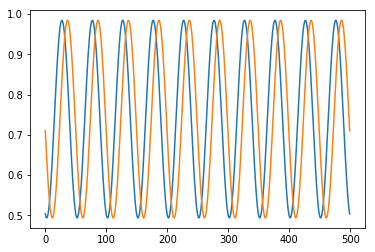

In [41]:
# #encode the data 
model = models_space['model_L0_0']
n_train, n_timesteps, _,_ = train_data.shape
train_encoded = torch.zeros((n_train, n_timesteps, 15,15))
val_encoded = torch.zeros((len(val_data), n_timesteps, 15,15))
data = torch.tensor(train_data).unsqueeze(2).float()

val_data_layer0 = torch.zeros((len(val_data), n_timesteps, 31,31))
for i in tqdm(range(len(train_data))):
    data_this = obtain_data_at_current_level(data[i], 0,3)
    encoded = encode(model, data_this, 0)
    train_encoded[i] = encoded[:,0]

data = torch.tensor(val_data).unsqueeze(2).float()
for i in tqdm(range(len(val_data))):
    data_this = obtain_data_at_current_level(data[i], 0,3)
#     print(data_this.shape)
    val_data_layer0[i] = data_this[:,0]
    encoded = encode(model, data_this, 0)
    val_encoded[i] = encoded[:,0]
    
#plot to make sure they are relatively the same 
plt.plot(val_encoded[1,:,0,0].cpu().detach().numpy())

plt.plot(train_encoded[0,:,0,0].cpu().detach().numpy())

In [15]:
#doing the time training
print("inside train_one_timestep")
i=None
j=None
step_size = 16
dt=1
n_forward = 5
arch = [225, 225*2, 225*2, 225*2, 225]
batch_size = 500
lr = 0.001
# if (i is not None) and (j is not None):
#     model_name = 'model_L{}_D{}_noise{}_i{}_j{}.pt'.format(current_size, step_size, noise, i, j)
# else:
model_name = 'model_L0_0_{}.pt'.format(step_size)#{}_D{}_noise{}.pt'.format(current_size, step_size, noise)
model_path_this = os.path.join(model_path, model_name)

dataset = utils.DataSet(train_encoded.flatten(start_dim=2), val_encoded.flatten(start_dim=2), val_encoded.flatten(start_dim=2), dt, step_size, n_forward)
print('create model {} ...'.format(model_name))
model = tnet.ResNet(arch=arch, dt=dt, step_size=step_size)

# # training
model.train_net(dataset, max_epoch=30000, batch_size=batch_size, lr=lr,
            model_path=os.path.join(model_path, model_name))

# # try: #if we already have a model saved
# #     if make_new:
# #         print("Making a new model. Old one deleted. model {}".format(model_name))
# #         assert False
# #     model_time = torch.load(model_path_this)
# #     print("model loaded: ", model_name)
# #     if dont_train: #just load model, no training
# #         print("Model not trained more")
# # #         return model_time
# # except:
# print('create model {} ...'.format(model_path_this))
# model_time = tnet.ResNet(train_data, val_data, step_size,
#                          model_name=model_name, model_dir=model_path, n_inputs=n_inputs,
#                          n_hidden_nodes=20, n_hidden_layers=5, out_dim=15*15,
#                          activation=nn.ReLU(), n_epochs=max_epochs,
#                          threshold=threshold, print_every=print_every,
#                          save_every=save_every)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print("device = ", device)
# model_time.to(device)

# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model_time.parameters())

# model_time.train_model(optimizer, criterion)

inside train_one_timestep
create model model_L0_0_16.pt ...


/home/kjohnst/multiscale_HiTS/src/utils.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.train_x = torch.tensor(train_data[:, x_idx, :]).float().to(self.device)
/home/kjohnst/multiscale_HiTS/src/utils.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.train_ys = torch.tensor(train_data[:, y_start_idx:y_end_idx:step_size, :]).float().to(self.device)
/home/kjohnst/multiscale_HiTS/src/utils.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.val_x = torch.tensor(val_data[:, x_idx, :]).float().to(self.device)
/home/kjohn

epoch 1000, training loss 0.0019822525791823864, validation loss 0.0020373703446239233
(--> new model saved @ epoch 1000)
epoch 2000, training loss 0.002250632969662547, validation loss 0.0022858635056763887
epoch 3000, training loss 0.0009477906278334558, validation loss 0.0009553001145832241
(--> new model saved @ epoch 3000)
epoch 4000, training loss 0.0009784643771126866, validation loss 0.0009931116364896297
epoch 5000, training loss 0.000985813094303012, validation loss 0.001012564287520945
epoch 6000, training loss 0.0006239430513232946, validation loss 0.0006358326645568013
(--> new model saved @ epoch 6000)
epoch 7000, training loss 0.000530685530975461, validation loss 0.0005481456173583865
(--> new model saved @ epoch 7000)
epoch 8000, training loss 0.0010818985756486654, validation loss 0.001096750027500093
epoch 9000, training loss 0.0014323045033961535, validation loss 0.001445509260520339
epoch 10000, training loss 0.0006970298127271235, validation loss 0.000715474307071

KeyboardInterrupt: 

In [19]:
# load models
step_sizes = [8,16]
models_time = list()
for step_size in step_sizes:
    print('model_L0_0_{}.pt'.format(step_size))
    models_time.append(torch.load(os.path.join(model_path,'model_L0_0_{}.pt'.format(step_size)),map_location='cpu'))
#     models.append(torch.load(os.path.join(model_path, 'model_D{}_noise0.0.pt'.format(step_size)), map_location='cpu'))

# fix model consistencies trained on gpus (optional)
for model in models_time:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

model_L0_0_8.pt
model_L0_0_16.pt


torch.Size([100, 500, 225])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([100, 500, 15, 15])
torch.Size([100, 225])


/home/kjohnst/multiscale_HiTS/src/ResNet.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


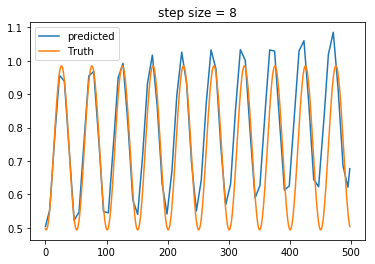

torch.Size([100, 500, 15, 15])
torch.Size([100, 225])


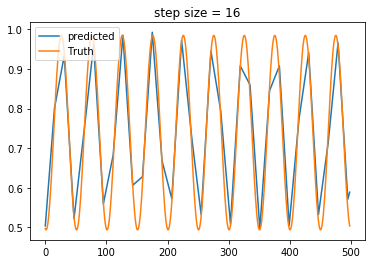

(array([-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. ]),
 <a list of 7 Text yticklabel objects>)

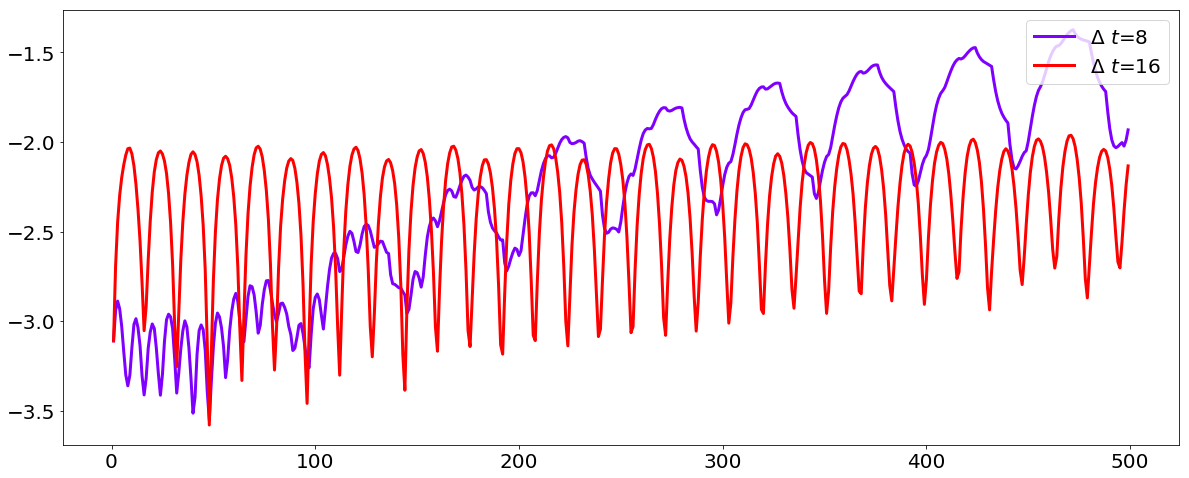

In [69]:
# uniscale time-stepping with NN
preds_mse = list()
times = list()

# test_data = val_data
ks = [1]
n_steps = val_encoded.shape[1] - 1
t = [dt*(step+1) for step in range(n_steps)]
criterion = torch.nn.MSELoss(reduction='none')

test_data = torch.tensor(val_encoded).flatten(start_dim=2).float()
print(test_data.shape)

n_steps = 499
for model in tqdm(models_time):
#     start = time.time()
    print(val_encoded.shape)
    print(val_encoded[:, 0, :].flatten(start_dim=1).float().shape)
    y_preds = model.uni_scale_forecast(torch.tensor(val_encoded[:, 0, :]).flatten(start_dim=1).float(), n_steps=n_steps)
#     end = time.time()
#     times.append(end - start)
    preds_mse.append(criterion(torch.tensor(val_encoded[:, 1:, :]).flatten(start_dim=2).float(), y_preds).mean(-1))
    for i in range(1):
        plt.plot(y_preds[1,:,i], label="predicted")
        plt.plot(test_data[1, 1:, i].detach().numpy(),label="Truth")
        x = y_preds[1,::model.step_size,i]
        
#         plt.plot(np.arange(len(x))*model.step_size,x, '.k')
#     plt.xlim([0,200])
    plt.legend()
    plt.title("step size = "+ str(model.step_size))
    plt.show()
    
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(step_sizes))))
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

torch.Size([100, 499, 225])
tensor(140)


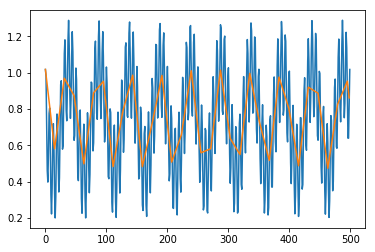

In [71]:
print(y_preds.shape)
print(np.argmax(y_preds[0,0]))
plt.plot(test_data[0,:,140].cpu().detach().numpy())
plt.plot(y_preds[0,:,140])

In [21]:
# model = models_time[0]
#get encoded versions of validation adn training
print(torch.tensor(test_data[:, 0, :]).float().shape)
y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
print(test_data.shape)
print(y_preds.shape)
encoded_t1_val = torch.reshape(y_preds, (100,499,15,15))
# print(encoded_t1.shape)
print(val_encoded.shape)

print(torch.tensor(train_encoded[:,0,:]).flatten(start_dim=2).float().shape)
y_preds = model.uni_scale_forecast(torch.tensor(train_encoded[:,0,:]).flatten(start_dim=1).float(), n_steps=n_steps)
print(y_preds.shape)
encoded_t1_train = torch.reshape(y_preds, (len(y_preds),n_steps,15,15))
print(encoded_t1_train.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


torch.Size([100, 225])


/home/kjohnst/multiscale_HiTS/src/ResNet.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))


torch.Size([100, 500, 225])
torch.Size([100, 499, 225])
torch.Size([100, 500, 15, 15])
torch.Size([500, 15, 15])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


torch.Size([500, 499, 225])
torch.Size([500, 499, 15, 15])


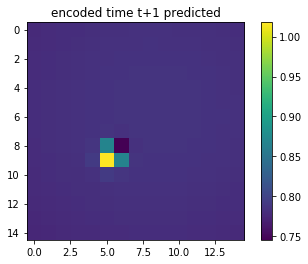

torch.Size([500, 1, 15, 15])


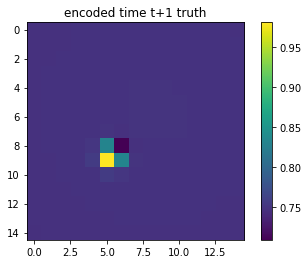

torch.Size([100, 500, 15, 15])
torch.Size([100, 499, 15, 15])


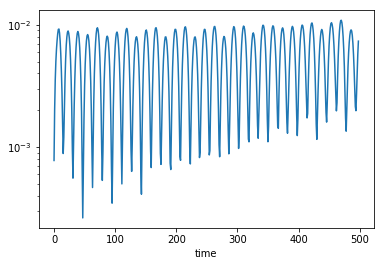

torch.Size([100, 499, 15, 15])
torch.Size([100, 499, 15, 15])


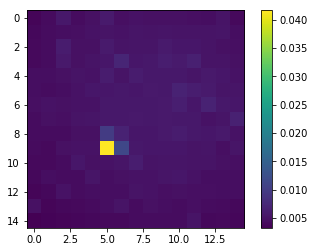

In [35]:
plt.imshow(encoded_t1_val[0,0])
plt.colorbar()
plt.title("encoded time t+1 predicted")
plt.show()

print(encoded.shape)
plt.imshow(val_encoded[0,1].cpu().detach().numpy())
plt.title("encoded time t+1 truth")
plt.colorbar()
plt.show()

print(torch.reshape(val_encoded, (100,500,15,15)).shape)
print(encoded_t1_val.shape)
mse = np.mean(((torch.reshape(val_encoded, (100,500,15,15))[:,1:] - encoded_t1_val)**2).cpu().detach().numpy(), axis=(0,2,3))
plt.xlabel("time")
plt.semilogy(mse)
plt.show()

print(torch.reshape(val_encoded, (100,500,15,15))[:,1:].shape)
print(encoded_t1_val.shape)
mse = np.mean(((torch.reshape(val_encoded, (100,500,15,15))[:,1:] - encoded_t1_val)**2).cpu().detach().numpy(), axis=(0,1))
plt.imshow(mse)
plt.colorbar()
plt.show()

In [38]:
# # trained models at different levels
# models_space = {}
# print('model names: model_L{level}_{index}')
# for file_name in sorted(os.listdir(model_path)):
#     model_name, _ = file_name.split('.')
#     print(model_name)
#     models_space[model_name] = torch.load(os.path.join(model_path, file_name))

model names: model_L{level}_{index}
model_L0_0
model_L0_0_16
model_L0_0_8
model_L0_1
model_L1_0
model_L1_1
model_L2_0


In [23]:
# model = models['model_L0_0']
# print(encoded_t1.shape)
# decoded = decode(model, encoded_t1,0)

# #decode the data 
model = models_space['model_L0_0']
print(encoded_t1_train.shape)
n_train, n_timesteps, _,_ = train_data.shape
train_decoded = torch.zeros((n_train, n_timesteps-1, 31,31))
val_decoded = torch.zeros((len(val_data), n_timesteps-1, 31,31))
data = encoded_t1_train.unsqueeze(2).float().to(device)
for i in tqdm(range(len(train_data))):
#     print(data[i].shape)
#     data_this = obtain_data_at_current_level(data[i], 0,3)
    decoded = decode(model, data[i], 0)
    print(decoded.shape)
#     print(train_encoded.shape)
#     print(encoded.shape)
    train_decoded[i] = decoded[:,0]

# data = torch.tensor(val_data).unsqueeze(2).float()
data = encoded_t1_val.unsqueeze(2).float().to(device)
for i in tqdm(range(len(val_data))):
#     print(data[i].shape)
#     data_this = obtain_data_at_current_level(data[i], 0,3)
    decoded = decode(model, data[i], 0)
    val_decoded[i] = decoded[:,0]
    

torch.Size([500, 499, 15, 15])


  0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([49

torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])


  0%|          | 0/100 [00:00<?, ?it/s]

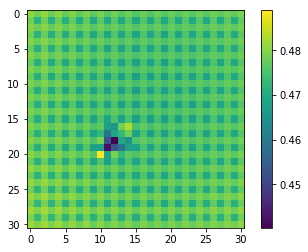

torch.Size([500, 1, 127, 127])


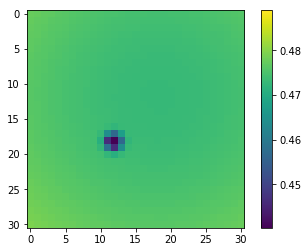

torch.Size([100, 500, 31, 31])
torch.Size([100, 499, 31, 31])


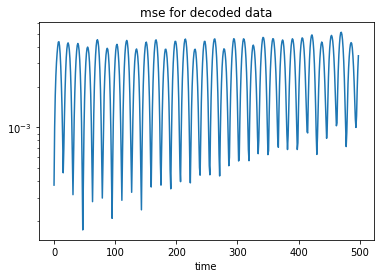

In [45]:
vmin = torch.min(train_decoded[0,0])
vmax = torch.max(train_decoded[0,0])

plt.imshow(train_decoded[0,0].cpu().detach().numpy(), vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

data = torch.tensor(train_data[0]).unsqueeze(1).float()
print(data.shape)
data_this = obtain_data_at_current_level(data, 0,3)
plt.imshow(data_this[0,0].cpu().detach().numpy(),vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

# print(train_decoded[0].shape)
# print(data_this[1:,0].shape)

print(val_data_layer0.shape)
print(val_decoded.shape)
mse = np.mean(((val_decoded.cpu() - val_data_layer0[:,1:].cpu())**2).cpu().detach().numpy(), axis=(0,2,3))
plt.xlabel("time")
plt.semilogy(mse)
plt.title("mse for decoded data")
plt.show()

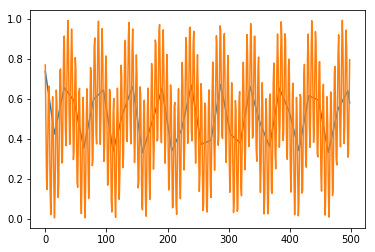

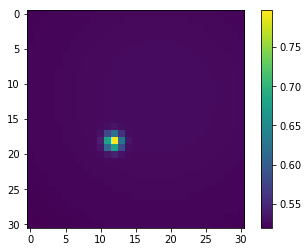

In [65]:
# plt.plot(val_decoded[0,:,12,18].cpu().detach().numpy())
# plt.plot(val_data_layer0[0,1:,12,18].cpu().detach().numpy())

plt.plot(val_decoded[0,:,18,12].cpu().detach().numpy())
plt.plot(val_data_layer0[0,1:,18,12].cpu().detach().numpy())
plt.show()

plt.imshow(val_data_layer0[0,0])
plt.colorbar()


torch.Size([500, 499, 31, 31])
torch.Size([500, 1, 31, 31])
torch.Size([500, 1, 127, 127])


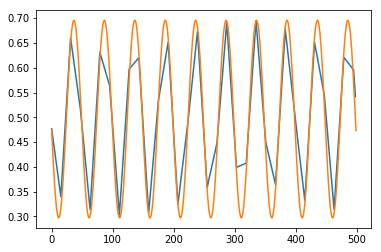

In [62]:
plt.plot(train_decoded[0,:,12,18].cpu().detach().numpy())
print(train_decoded.shape)
print(data_this.shape)
data = torch.tensor(train_data[0]).unsqueeze(1).float()
print(data.shape)
data_this = obtain_data_at_current_level(data, 0,3)
plt.plot(data_this[:,0, 12, 18].cpu().detach().numpy())

Animating, may take a little while...
..................Done! gif saved to  decoded_0_0.gif


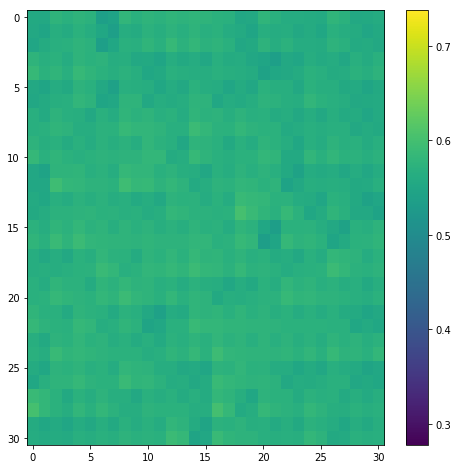

In [61]:
#animate the first decoded

def animate(snapshots, normalize = True, file_name = "animation.gif"):
    """
    Makes an animation of snapshots in time
    
    inputs:
    snapshots: np.array of size (n_time_steps,1, dim, dim)
    normalize = True: whether to fix axis between 0 and 1 or not
    file_name = "animation.gif": file name of where to save gif
    
    outputs:
    no returned output
    gif saved to file_name
    """


    fps = 30
    nSeconds = len(snapshots)/fps
    
    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure( figsize=(8,8) )

    a = snapshots[0,:,:,:][0].T
    if normalize:
        im = plt.imshow(a, interpolation='none', aspect='auto', vmin=0.0, vmax=1.0)
    else:
        im = plt.imshow(a, interpolation='none', aspect='auto', vmin=np.min(snapshots), vmax=np.max(snapshots))
    plt.colorbar()

    print("Animating, may take a little while...")

    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )

        im.set_array(snapshots[i,:,:,:,][0].T)
        return [im]

    anim = animation.FuncAnimation(
                                   fig,
                                   animate_func,
                                   frames = int(nSeconds * fps),
                                   interval = 1000 / fps, # in ms
                                   )
    writergif = animation.PillowWriter(fps=30)
    anim.save(file_name, writer=writergif)

    print('Done! gif saved to ', file_name)
    
to_animate = val_decoded[0].unsqueeze(1).cpu().detach().numpy()
animate(to_animate, False, 'decoded_0_0.gif')

In [55]:
val_decoded[0].unsqueeze(1).shape

torch.Size([499, 1, 31, 31])